# 4.1 — Elemental Encoder Comparison

This notebook trains CrabNet with **8 different elemental embeddings**
(without Pettifor `extend_features`) to evaluate encoder sensitivity.

It includes the 7 built-in CrabNet encoders **plus** the Pettifor
similarity matrix registered as a custom `elem_prop`.

> **Important**: CrabNet v2.0.8 has a bug where `elem_prop` is not
> propagated to the `Embedder`, silently defaulting all models to
> `mat2vec`. A monkey-patch is applied below to fix this.

Encoders tested:
`jarvis`, `magpie`, `mat2vec`, `oliynyk`, `onehot`, `ptable`, `random_200`, `pettifor`

In [1]:
from __future__ import annotations

import warnings
warnings.filterwarnings('ignore')

import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Patch SWA for PyTorch >= 2.x compatibility ---
from crabnet.utils.optim import SWA  # type: ignore
_original_swa_init = SWA.__init__
def _patched_swa_init(self, *args, **kwargs):
    _original_swa_init(self, *args, **kwargs)
    if not hasattr(self, '_optimizer_step_pre_hooks'):
        self._optimizer_step_pre_hooks = {}
    if not hasattr(self, '_optimizer_step_post_hooks'):
        self._optimizer_step_post_hooks = {}
SWA.__init__ = _patched_swa_init
# ------------------------------------------------

# --- Patch CrabNet elem_prop propagation bug ---
import tf_chpvk_pv.modeling.CrabNet.patches as _patches
importlib.reload(_patches)                    # pick up code changes without kernel restart
_patches.patch_crabnet_elem_prop()
# ------------------------------------------------

from crabnet.crabnet_ import CrabNet          # type: ignore
from crabnet.utils.data import groupby_formula # type: ignore

from tf_chpvk_pv.config import TRAINED_MODELS, FIGURES_DIR
from tf_chpvk_pv.modeling.CrabNet.utils import (
    DEVICE,
    get_raw_data,
    get_pettifor_features,
    register_pettifor_elem_prop,
    test_r2_score,
)

print(f'Device: {DEVICE}')

2026-02-18 17:11:05.860 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


2026-02-18 17:11:06.567 | INFO     | tf_chpvk_pv.modeling.CrabNet.utils:<module>:20 - CrabNet device: cuda
[patch] CrabNet elem_prop propagation fixed.
Device: cuda


## Data Preparation

Load, clean, group, and split exactly as in notebook 4. Pettifor columns
are computed (to get the same train/val/test split) but then **dropped**
before training.

In [2]:
df = get_raw_data()
df.rename(columns={'bandgap': 'target', 'reduced_formulas': 'formula'}, inplace=True)

df_grouped = groupby_formula(df, how='median')

for formula in df_grouped['formula']:
    df_grouped.loc[df_grouped['formula'] == formula, 'source'] = (
        df.loc[df['formula'] == formula, 'source'].values[0]
    )
df_grouped_no_src = df_grouped.drop(columns=['source'])

train_df, val_df, test_df, feature_names = get_pettifor_features(
    df_grouped_no_src, original_df=df, train=True
)

# Register Pettifor as a CrabNet elem_prop (so it can be used like mat2vec, etc.)
register_pettifor_elem_prop()

# Drop Pettifor columns — encoder comparison uses only the elemental embedding
train_base = train_df.drop(columns=feature_names)
val_base   = val_df.drop(columns=feature_names)
test_base  = test_df.drop(columns=feature_names)

print(f'Train: {len(train_base)}  |  Val: {len(val_base)}  |  Test: {len(test_base)}')

The data comes from the following sources:
74.16 % from halide perovskites,
0.0261 % from chalcogenides perovskites,
25.82 % from chalcogenide semiconductors
2026-02-18 17:11:54.461 | INFO     | tf_chpvk_pv.modeling.CrabNet.utils:register_pettifor_elem_prop:395 - Pettifor elem_prop already registered at /home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/data/element_properties/pettifor.csv
Train: 2902  |  Val: 363  |  Test: 363


## Train & Evaluate Each Encoder


Encoder: magpie

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11896070 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 13649.65formulae/s]

skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

loading data with up to 9 elements in the formula
training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 23581.39formulae/s]


skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.455 val mae: 0.456


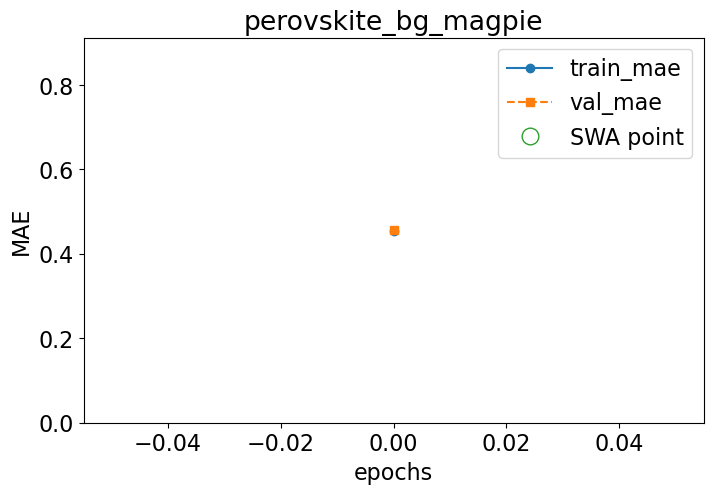

Epoch: 19/300 --- train mae: 0.331 val mae: 0.337


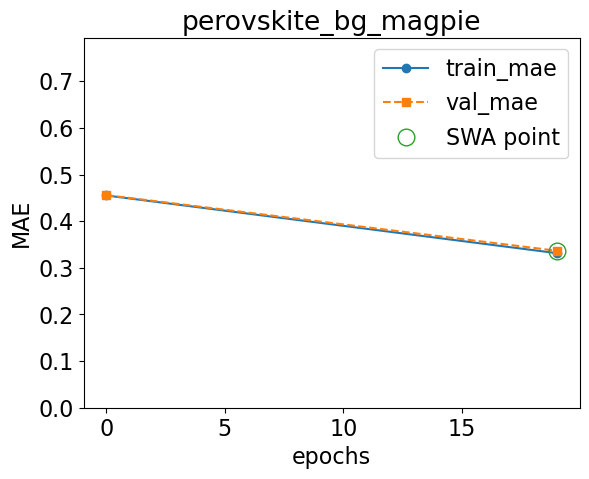

Epoch: 39/300 --- train mae: 0.28 val mae: 0.31


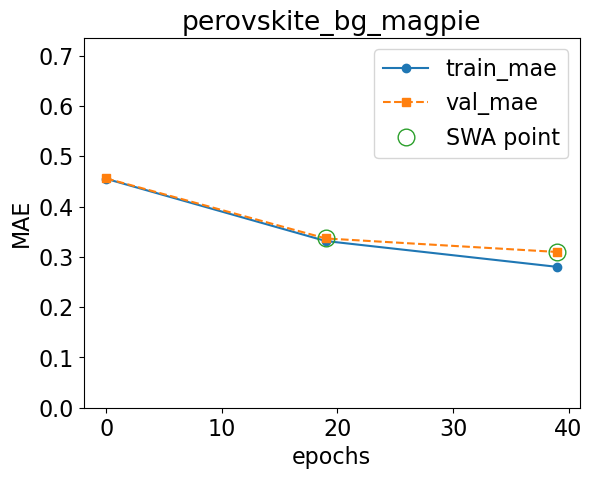

Epoch: 59/300 --- train mae: 0.239 val mae: 0.3


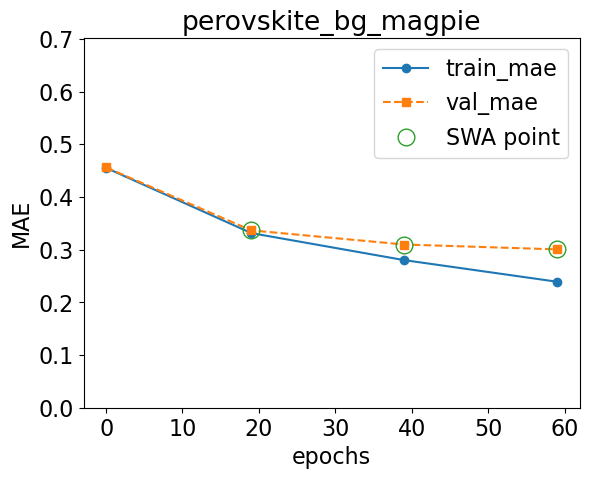

Epoch: 79/300 --- train mae: 0.228 val mae: 0.297


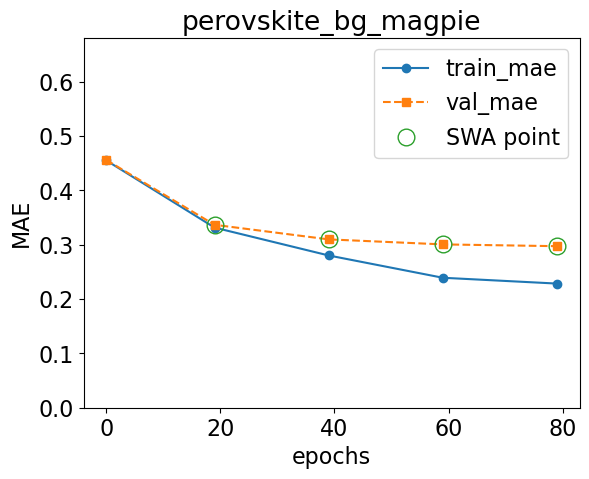

Epoch: 99/300 --- train mae: 0.215 val mae: 0.285


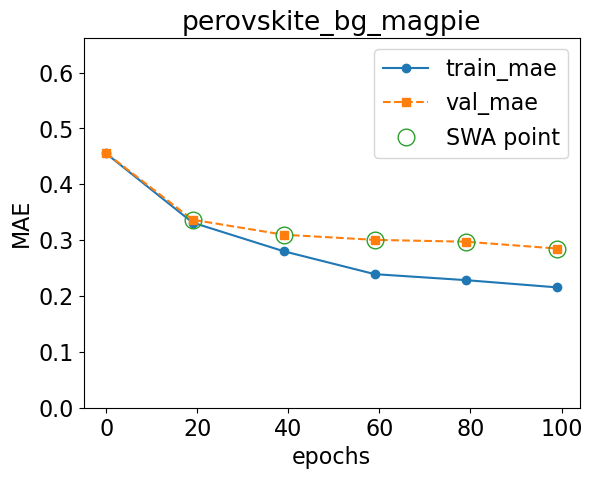

Epoch: 119/300 --- train mae: 0.201 val mae: 0.281


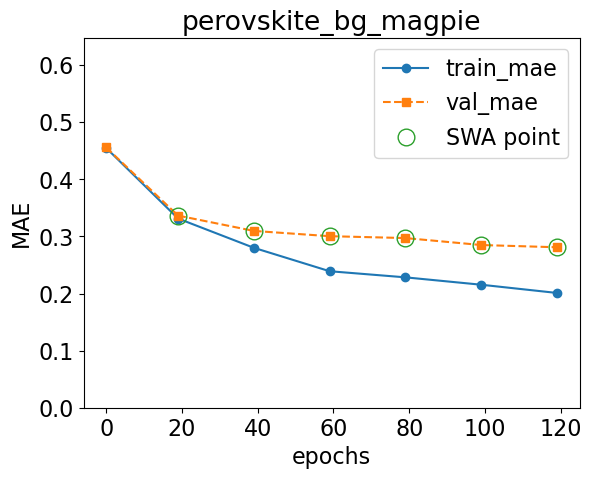

Epoch: 139/300 --- train mae: 0.188 val mae: 0.279


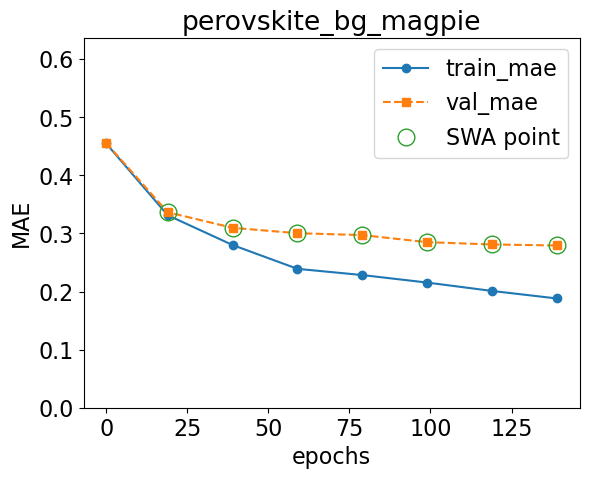

Epoch: 159/300 --- train mae: 0.179 val mae: 0.283


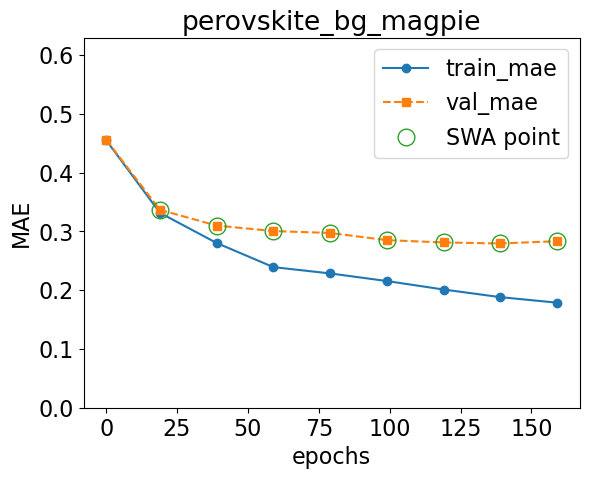

Epoch: 179/300 --- train mae: 0.185 val mae: 0.274


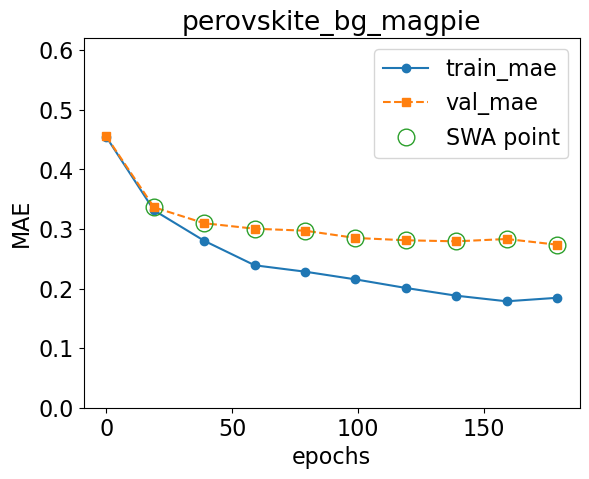

Epoch: 199/300 --- train mae: 0.164 val mae: 0.276


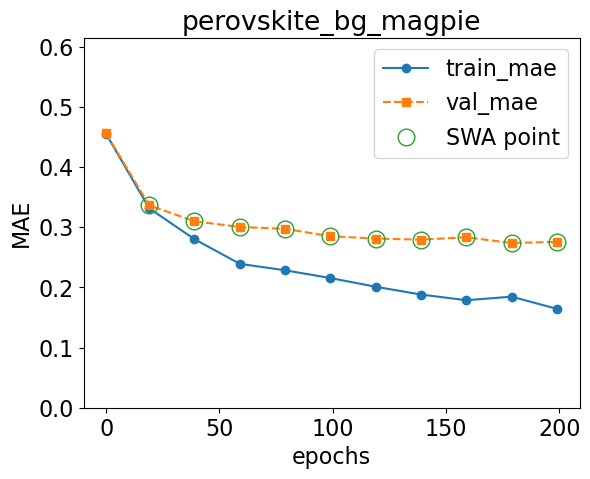

Epoch: 219/300 --- train mae: 0.151 val mae: 0.273


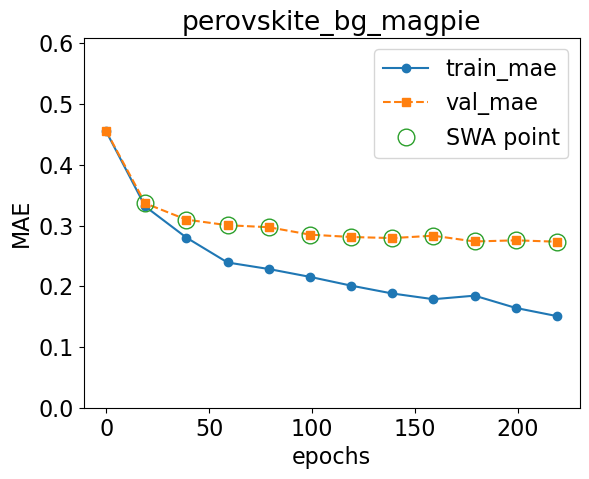

Epoch: 239/300 --- train mae: 0.141 val mae: 0.27


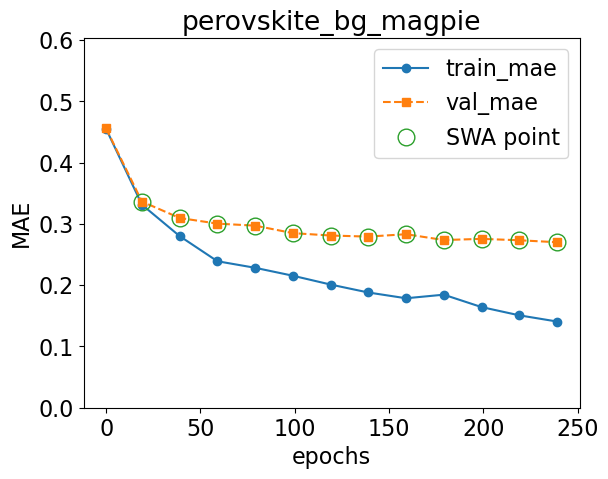

Epoch: 259/300 --- train mae: 0.131 val mae: 0.268


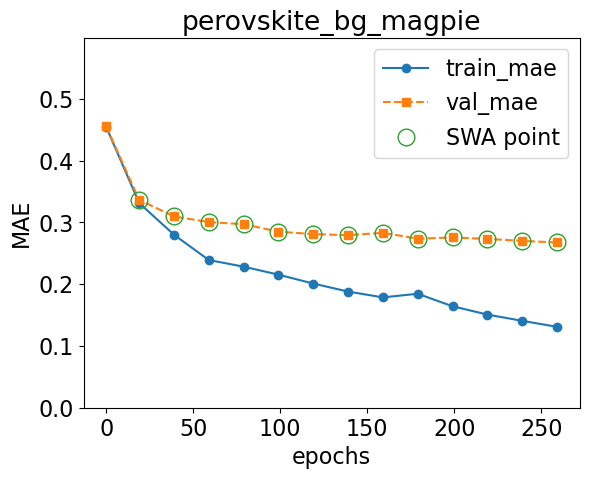

Epoch: 279/300 --- train mae: 0.128 val mae: 0.261


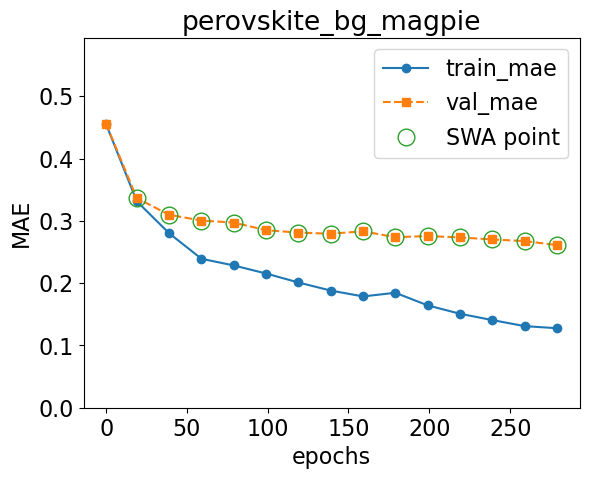

Epoch 299 failed to improve.
Discarded: 1/3 weight updates
Epoch: 299/300 --- train mae: 0.121 val mae: 0.268


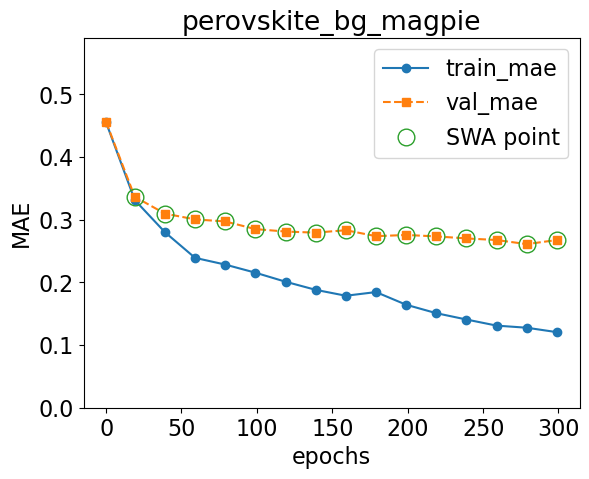

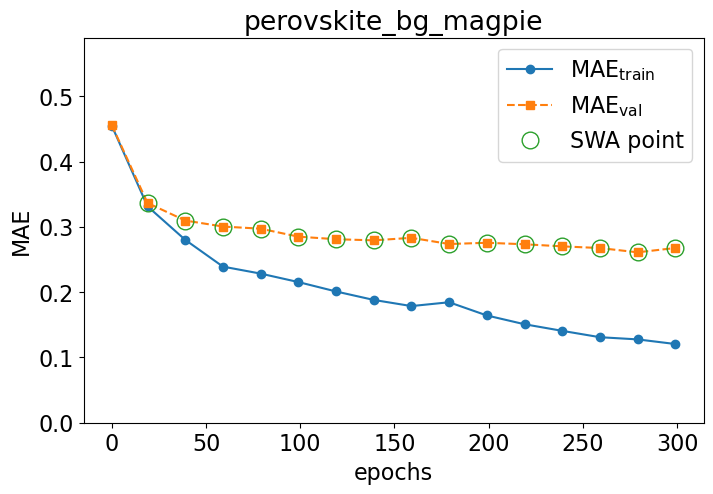

Saving network (perovskite_bg_magpie) to models/trained_models/perovskite_bg_magpie.pth


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 55064.46formulae/s]


skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
R2 score: 0.3464
MSE: 0.2826
MAE: 0.2725 eV

Encoder: mat2vec

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 92038.22formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 97417.13formulae/s]

skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 0.453 val mae: 0.453


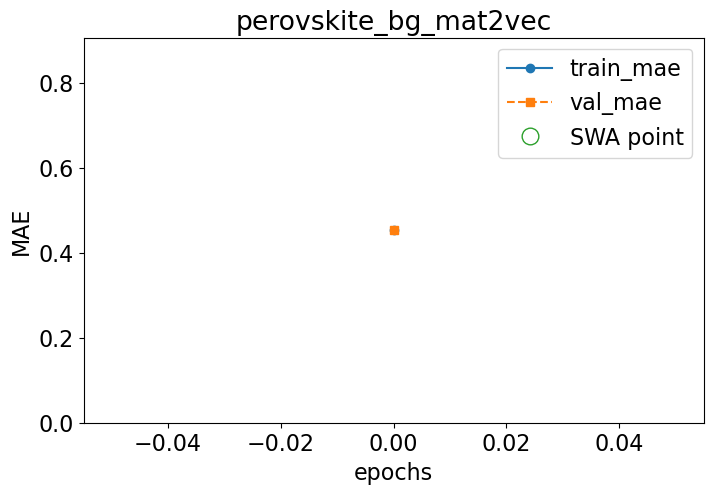

Epoch: 19/300 --- train mae: 0.245 val mae: 0.294


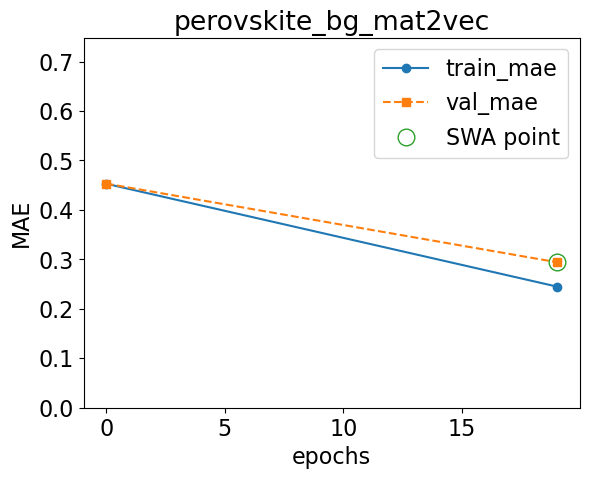

Epoch: 39/300 --- train mae: 0.162 val mae: 0.28


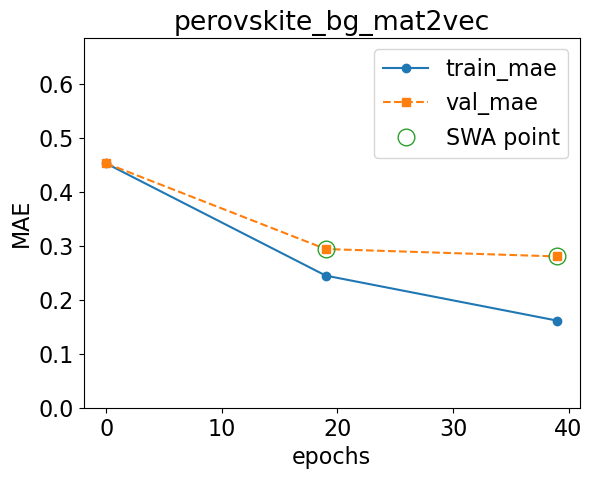

Epoch: 59/300 --- train mae: 0.111 val mae: 0.268


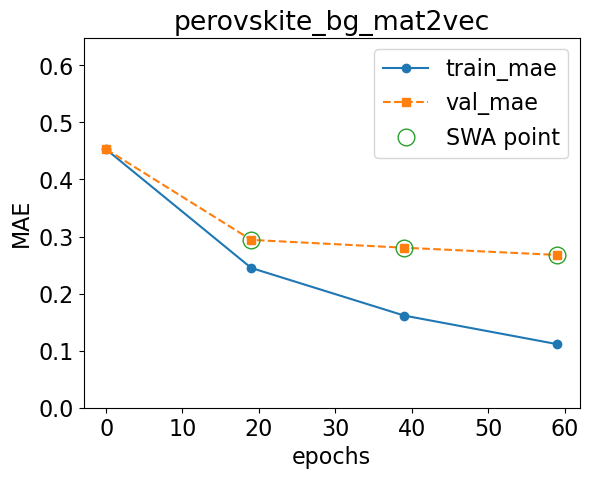

Epoch: 79/300 --- train mae: 0.0834 val mae: 0.265


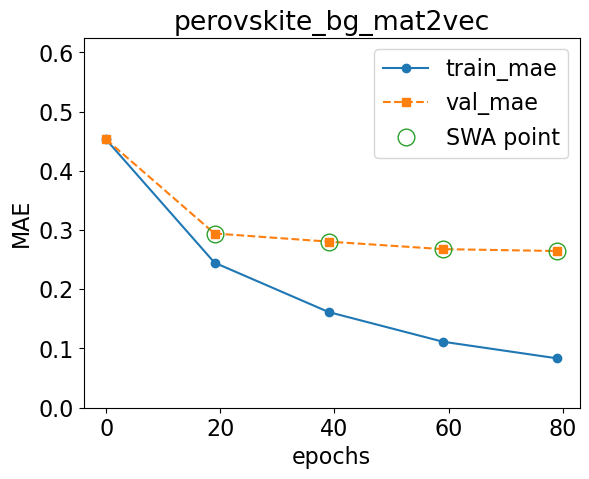

Epoch: 99/300 --- train mae: 0.0639 val mae: 0.264


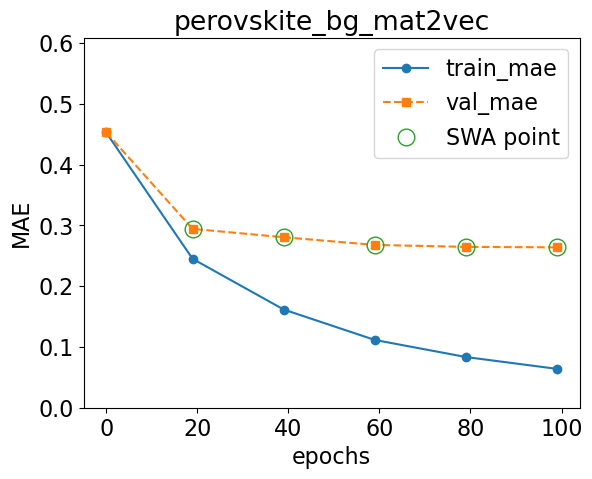

Epoch 119 failed to improve.
Discarded: 1/3 weight updates
Epoch: 119/300 --- train mae: 0.0526 val mae: 0.264


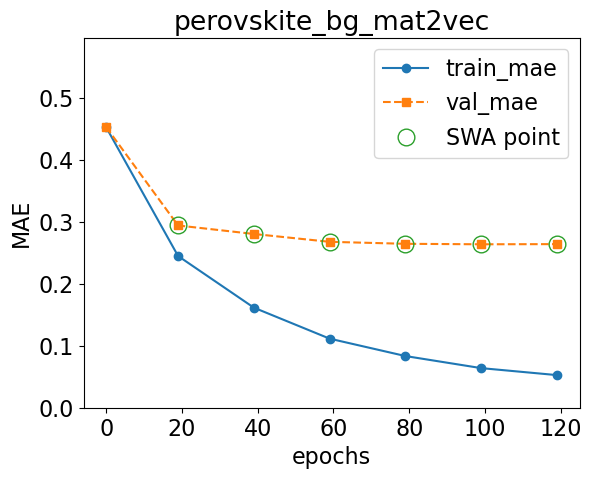

Epoch: 139/300 --- train mae: 0.0444 val mae: 0.265


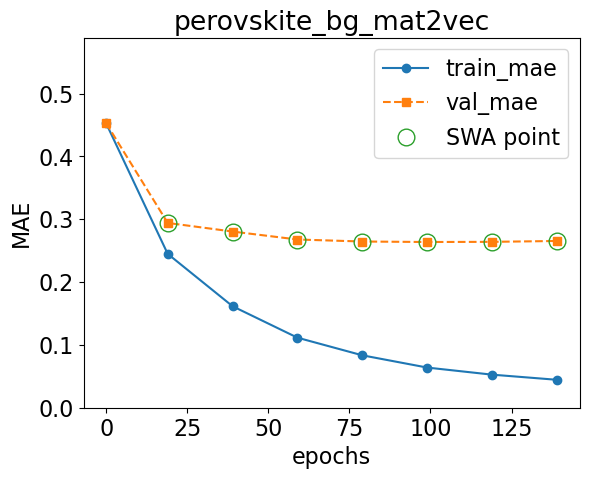

Epoch: 159/300 --- train mae: 0.0392 val mae: 0.261


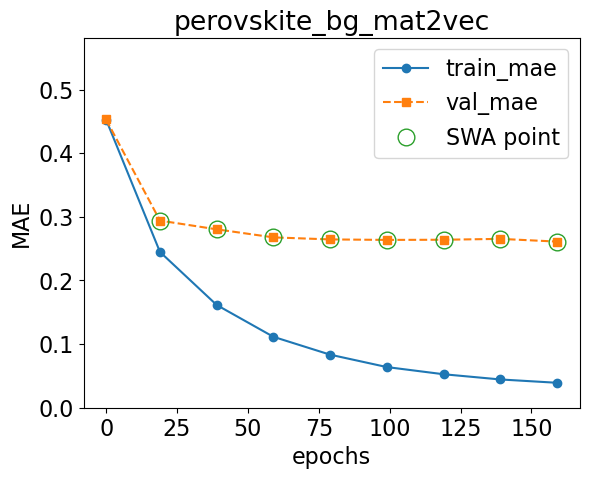

Epoch: 179/300 --- train mae: 0.0348 val mae: 0.26


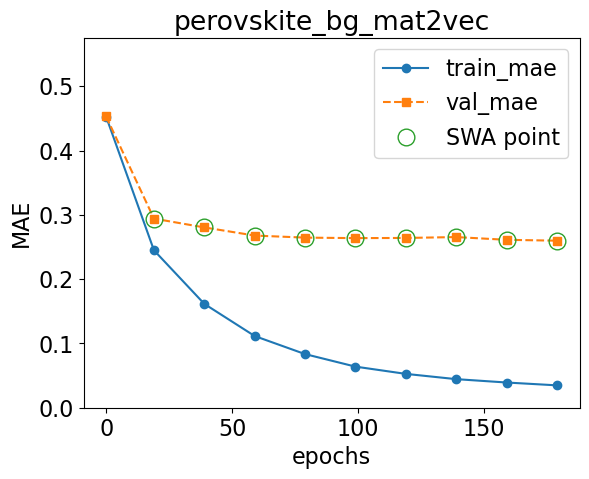

Epoch: 199/300 --- train mae: 0.0317 val mae: 0.259


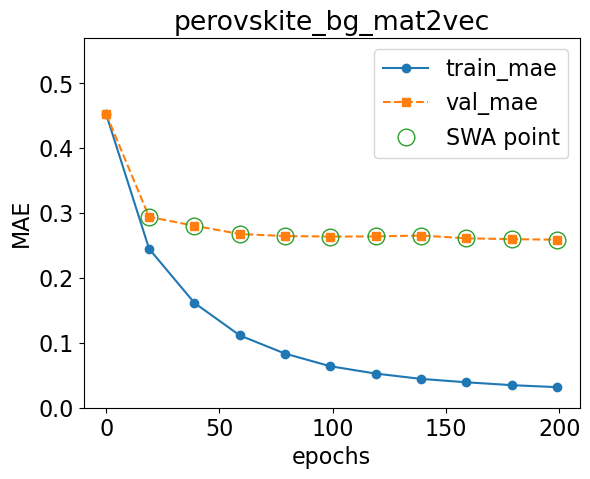

Epoch: 219/300 --- train mae: 0.0302 val mae: 0.256


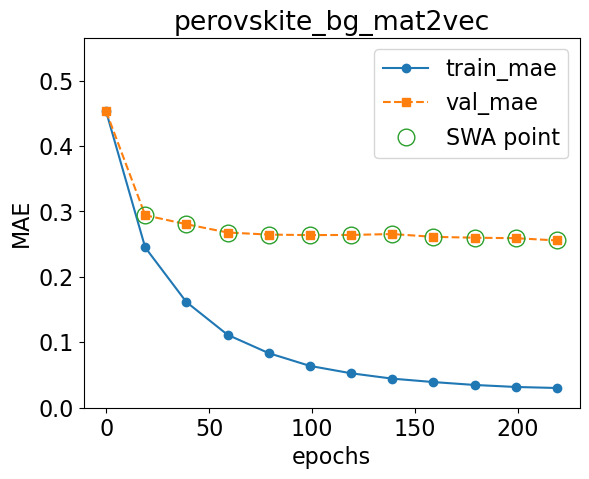

Epoch: 239/300 --- train mae: 0.0278 val mae: 0.257


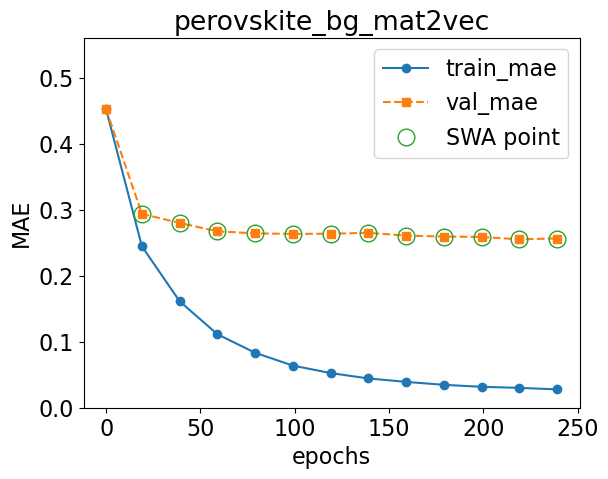

Epoch: 259/300 --- train mae: 0.0271 val mae: 0.258


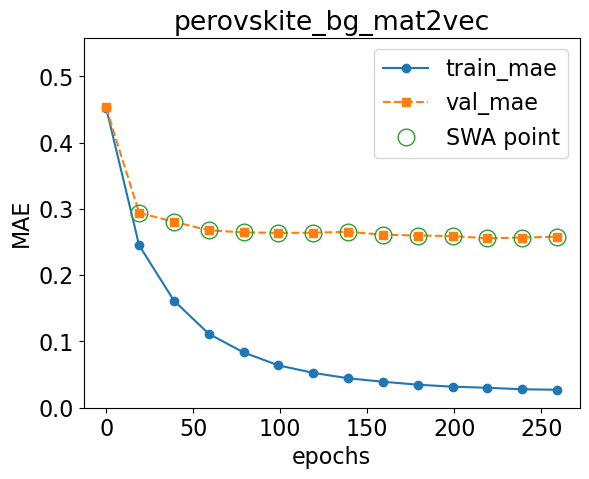

Epoch: 279/300 --- train mae: 0.0257 val mae: 0.257


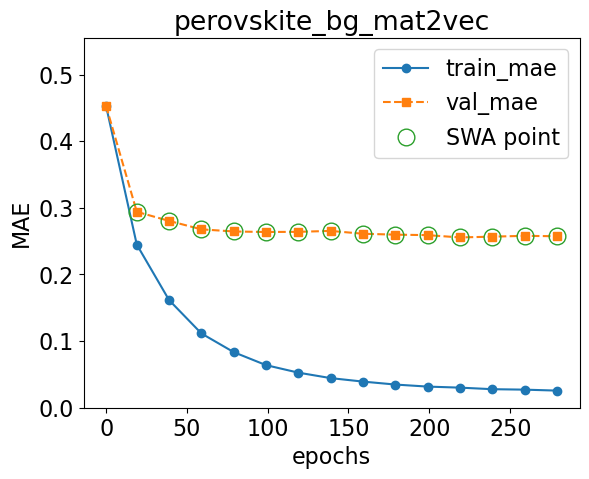

Epoch 299 failed to improve.
Discarded: 2/3 weight updates
Epoch: 299/300 --- train mae: 0.0248 val mae: 0.259


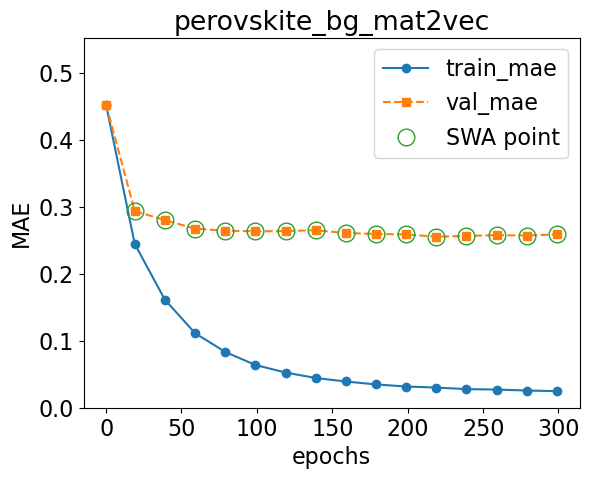

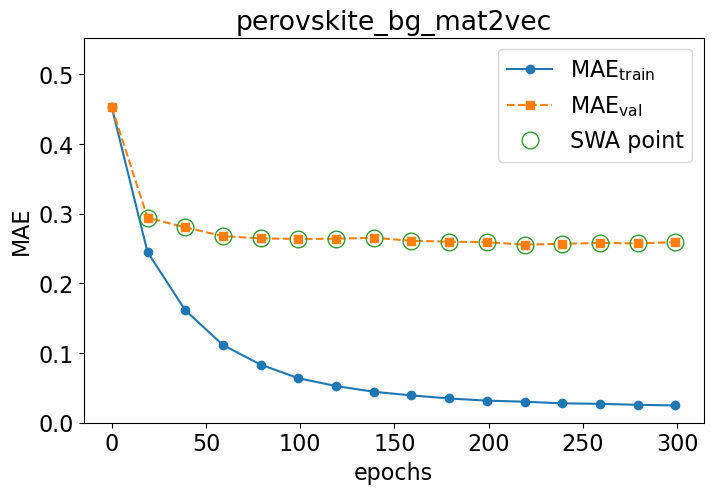

Saving network (perovskite_bg_mat2vec) to models/trained_models/perovskite_bg_mat2vec.pth


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 98775.94formulae/s]


skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
R2 score: 0.3407
MSE: 0.2851
MAE: 0.2605 eV

Encoder: onehot

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11945222 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 111169.80formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 110737.68formulae/s]

skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 0.463 val mae: 0.465


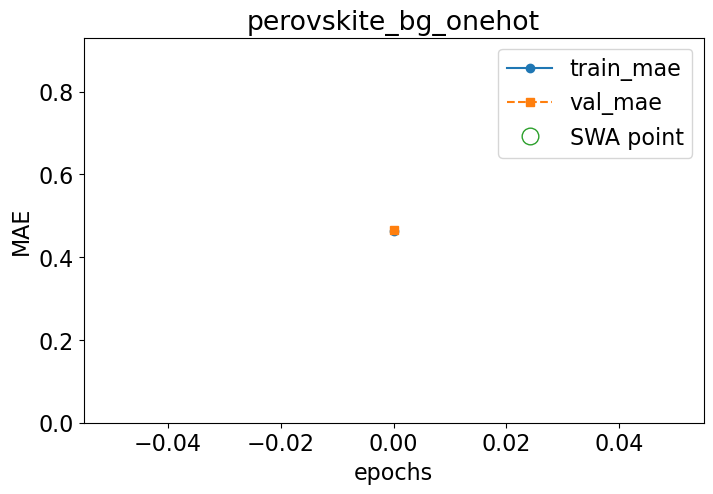

Epoch: 19/300 --- train mae: 0.275 val mae: 0.312


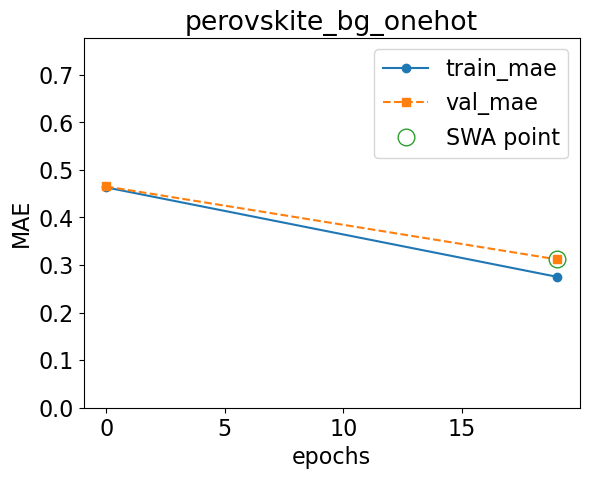

Epoch: 39/300 --- train mae: 0.199 val mae: 0.29


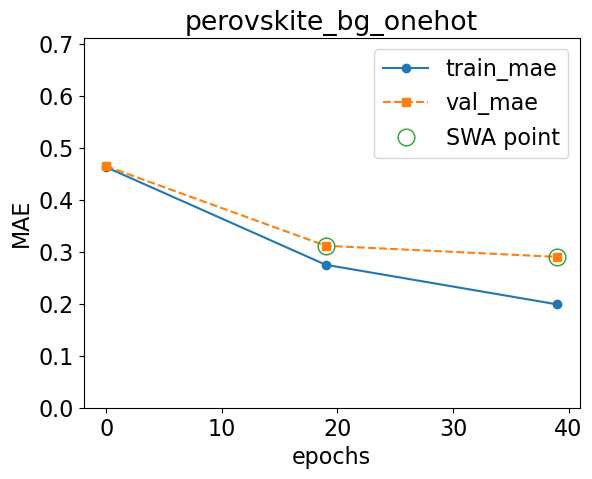

Epoch: 59/300 --- train mae: 0.135 val mae: 0.28


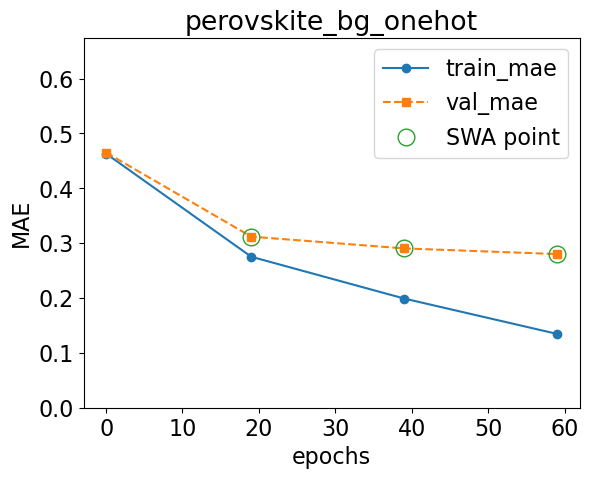

Epoch: 79/300 --- train mae: 0.0919 val mae: 0.27


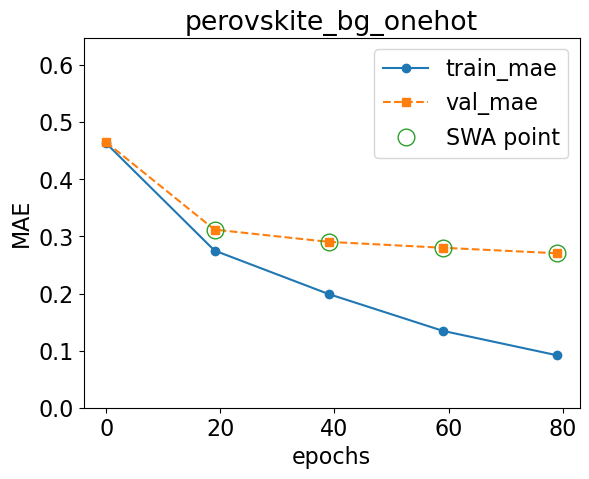

Epoch: 99/300 --- train mae: 0.0686 val mae: 0.269


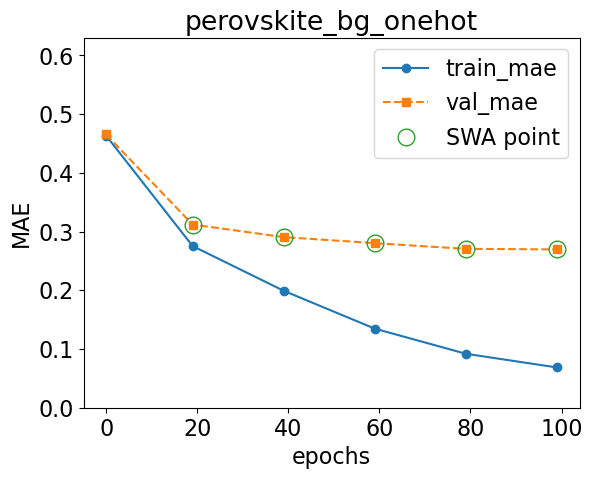

Epoch: 119/300 --- train mae: 0.0537 val mae: 0.266


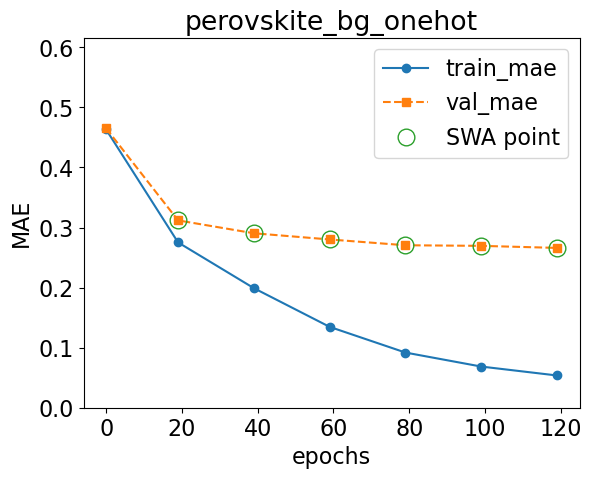

Epoch 139 failed to improve.
Discarded: 1/3 weight updates
Epoch: 139/300 --- train mae: 0.0422 val mae: 0.271


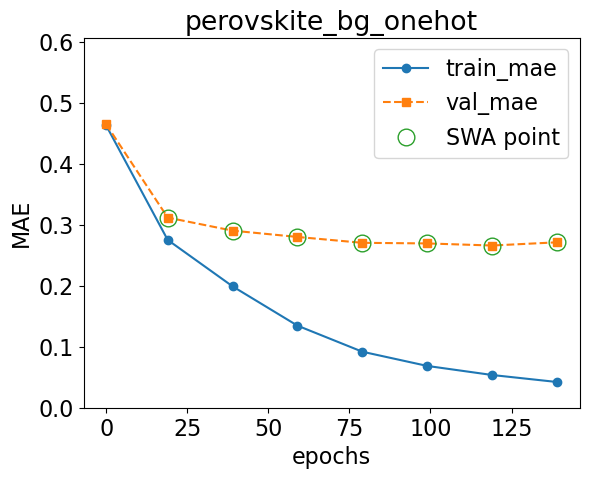

Epoch: 159/300 --- train mae: 0.0368 val mae: 0.267


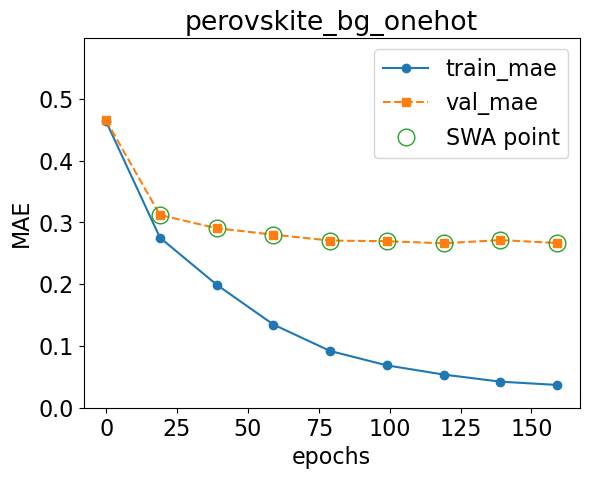

Epoch 179 failed to improve.
Discarded: 2/3 weight updates
Epoch: 179/300 --- train mae: 0.0324 val mae: 0.272


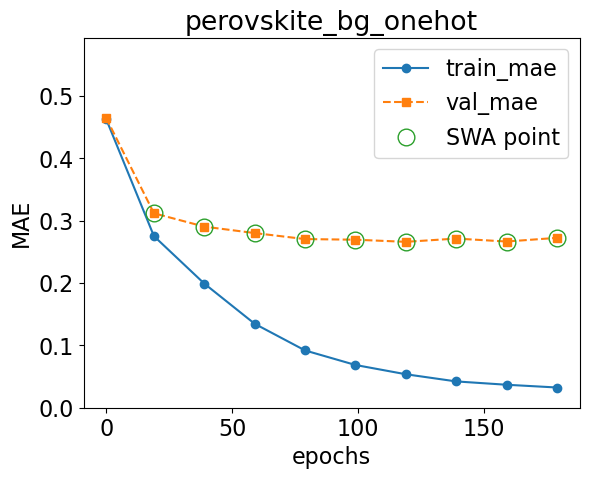

Epoch 199 failed to improve.
Discarded: 3/3 weight updates
Epoch: 199/300 --- train mae: 0.0294 val mae: 0.273


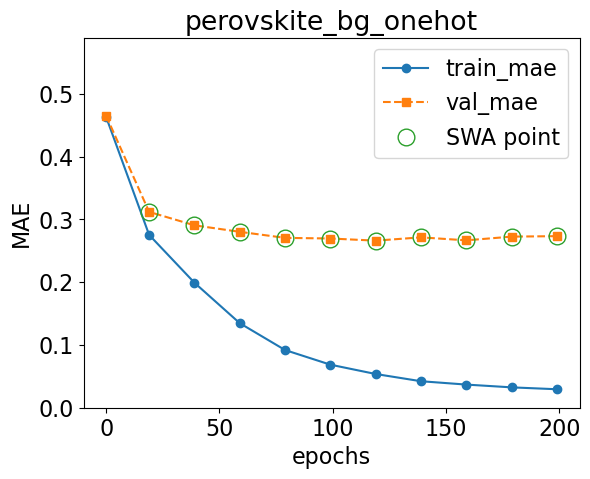

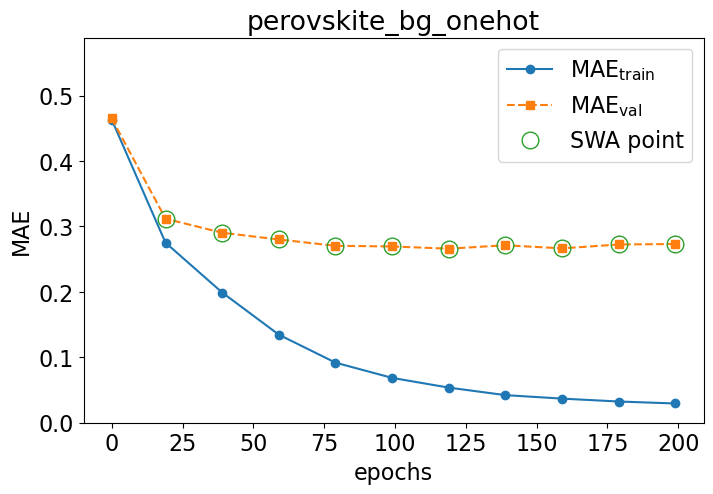

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_onehot) to models/trained_models/perovskite_bg_onehot.pth


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 111149.97formulae/s]


skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
R2 score: 0.3799
MSE: 0.2681
MAE: 0.2562 eV

Encoder: random_200

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 63436.46formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 49695.87formulae/s]


skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.463 val mae: 0.465


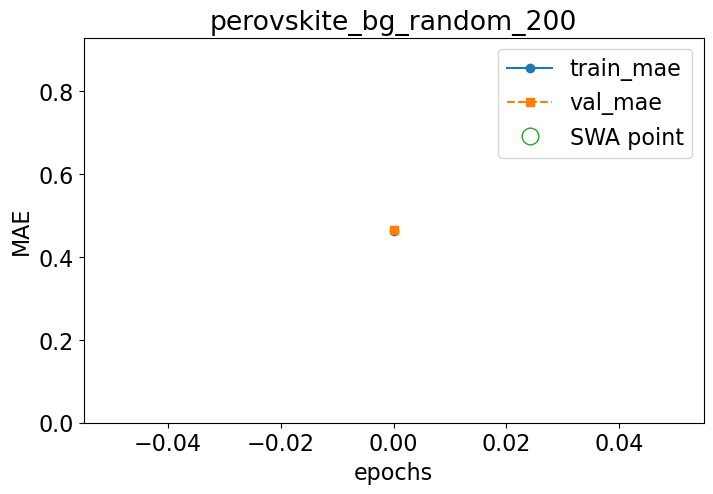

Epoch: 19/300 --- train mae: 0.301 val mae: 0.329


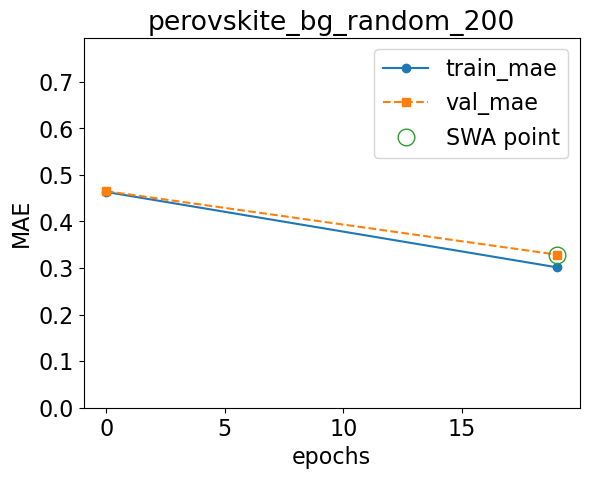

Epoch: 39/300 --- train mae: 0.215 val mae: 0.302


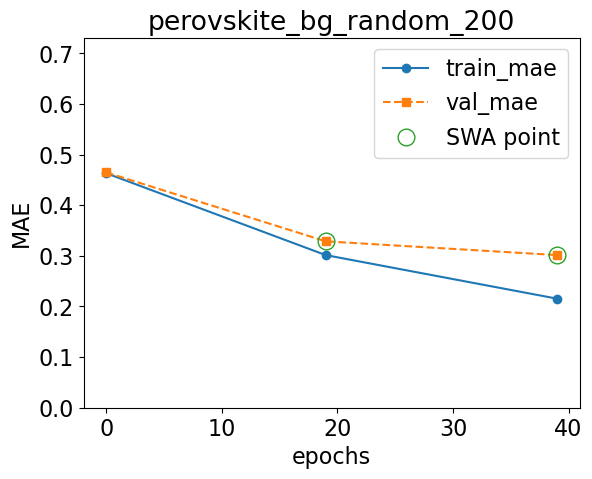

Epoch: 59/300 --- train mae: 0.154 val mae: 0.291


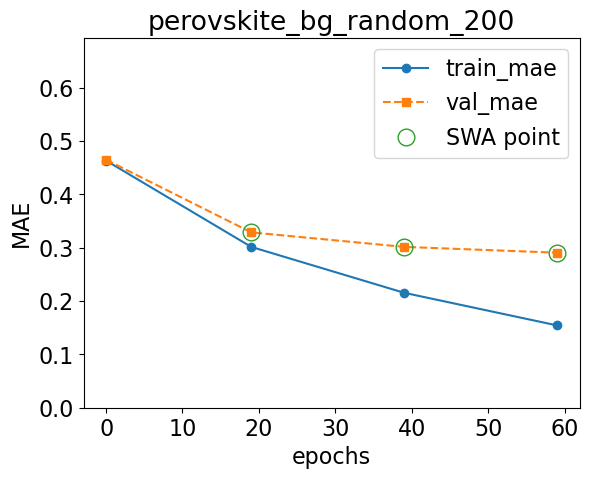

Epoch: 79/300 --- train mae: 0.106 val mae: 0.283


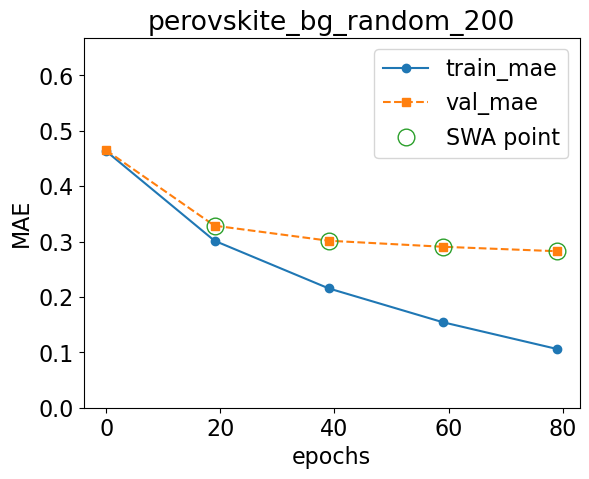

Epoch: 99/300 --- train mae: 0.0774 val mae: 0.273


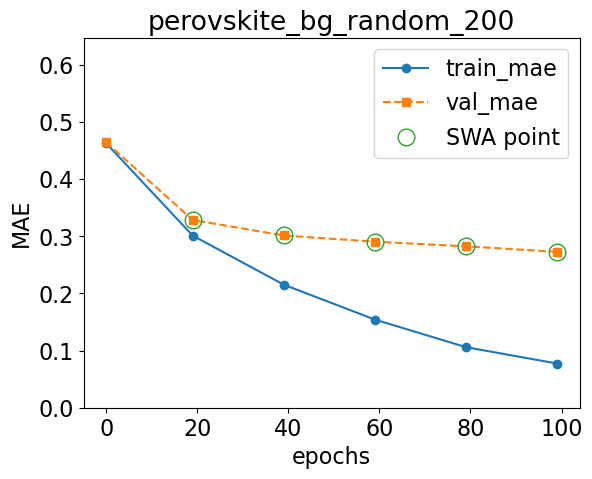

Epoch: 119/300 --- train mae: 0.0617 val mae: 0.276


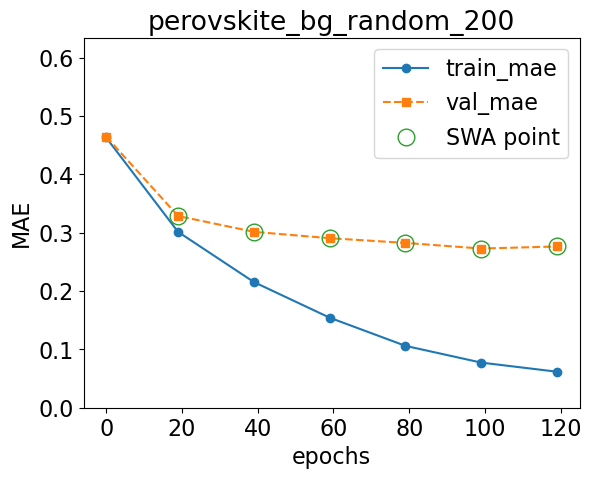

Epoch: 139/300 --- train mae: 0.0514 val mae: 0.276


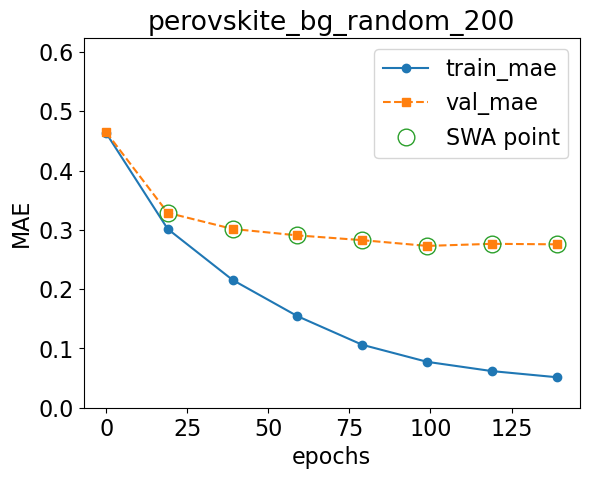

Epoch: 159/300 --- train mae: 0.0426 val mae: 0.271


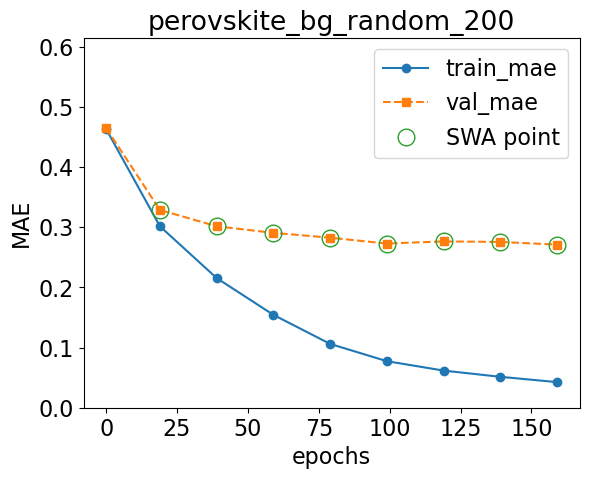

Epoch: 179/300 --- train mae: 0.0383 val mae: 0.272


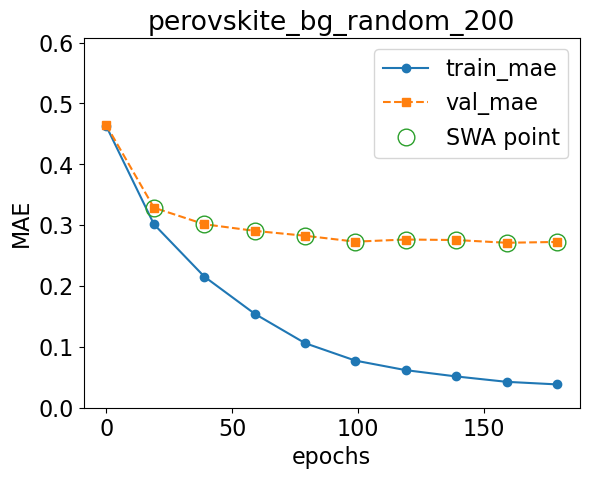

Epoch 199 failed to improve.
Discarded: 1/3 weight updates
Epoch: 199/300 --- train mae: 0.0333 val mae: 0.279


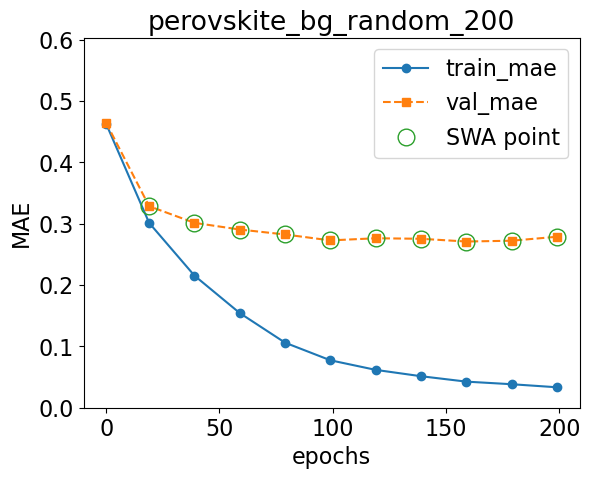

Epoch 219 failed to improve.
Discarded: 2/3 weight updates
Epoch: 219/300 --- train mae: 0.0318 val mae: 0.277


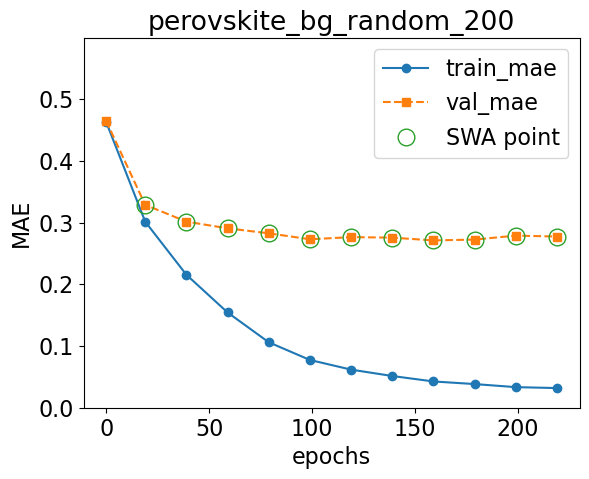

Epoch 239 failed to improve.
Discarded: 3/3 weight updates
Epoch: 239/300 --- train mae: 0.0291 val mae: 0.277


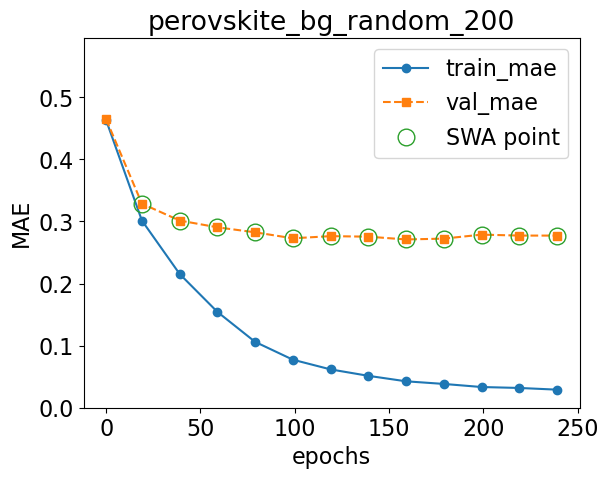

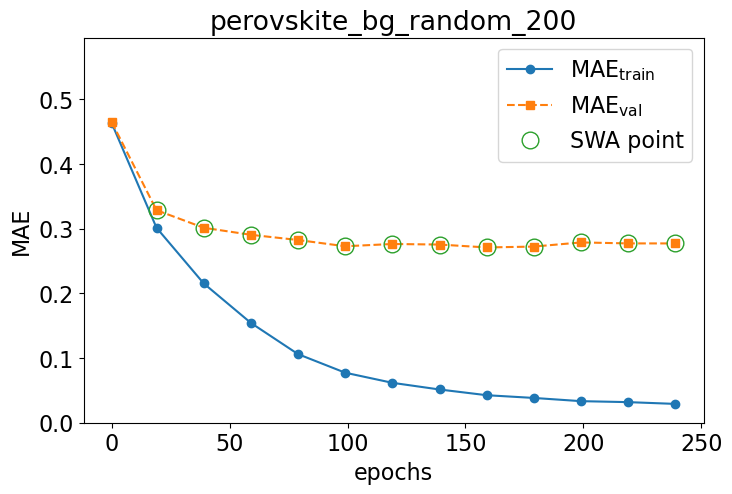

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_random_200) to models/trained_models/perovskite_bg_random_200.pth


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 187920.56formulae/s]

skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula


R2 score: 0.3674
MSE: 0.2736
MAE: 0.2622 eV

Encoder: pettifor

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11934982 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 124507.67formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 140467.97formulae/s]

skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 0.454 val mae: 0.455


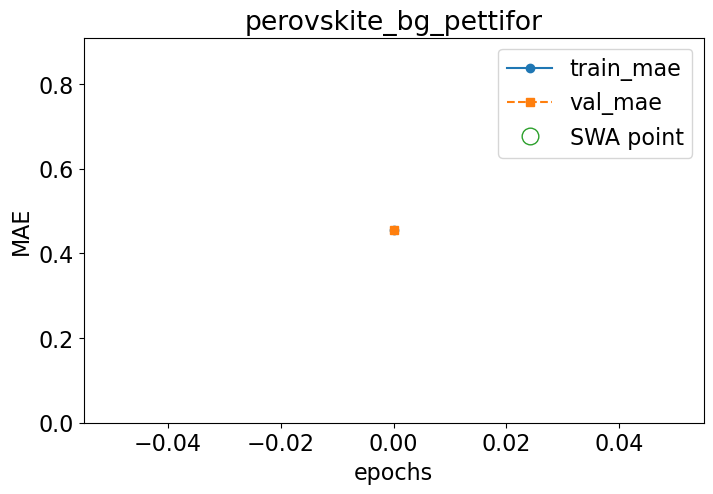

Epoch: 19/300 --- train mae: 0.28 val mae: 0.307


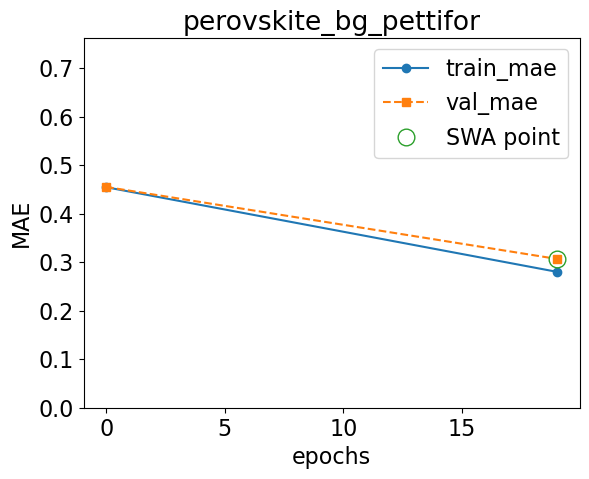

Epoch: 39/300 --- train mae: 0.202 val mae: 0.282


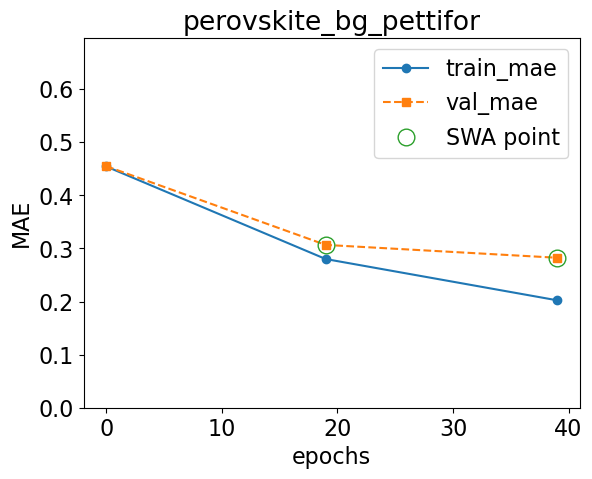

Epoch: 59/300 --- train mae: 0.144 val mae: 0.271


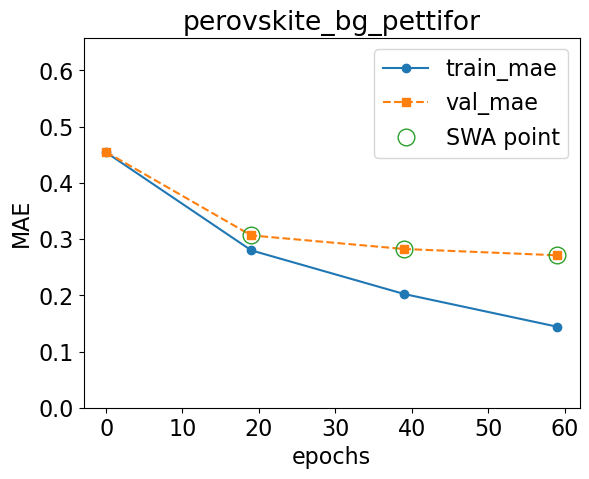

Epoch: 79/300 --- train mae: 0.104 val mae: 0.263


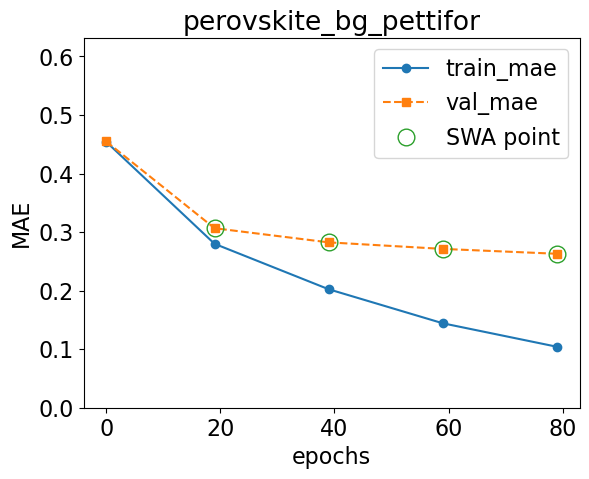

Epoch: 99/300 --- train mae: 0.0762 val mae: 0.261


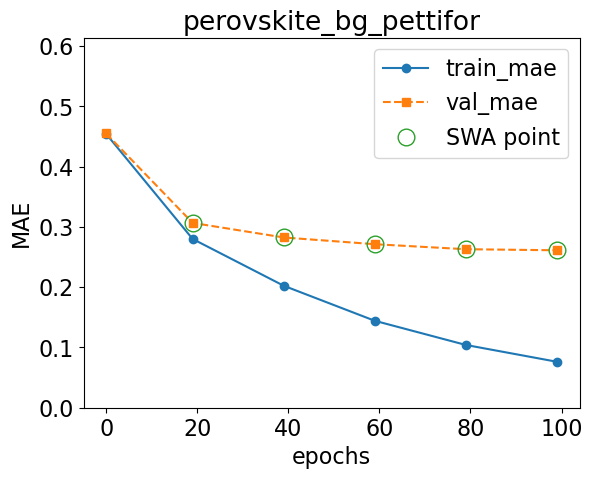

Epoch: 119/300 --- train mae: 0.0589 val mae: 0.258


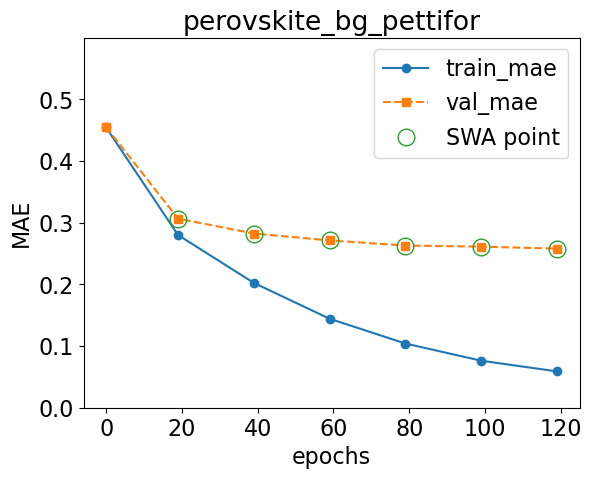

Epoch: 139/300 --- train mae: 0.0492 val mae: 0.255


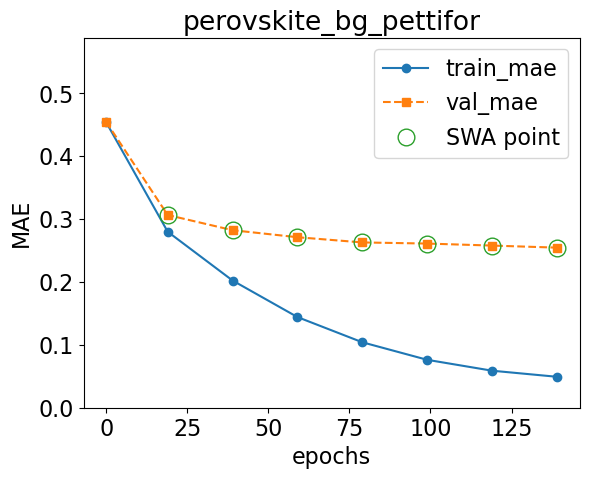

Epoch: 159/300 --- train mae: 0.0409 val mae: 0.255


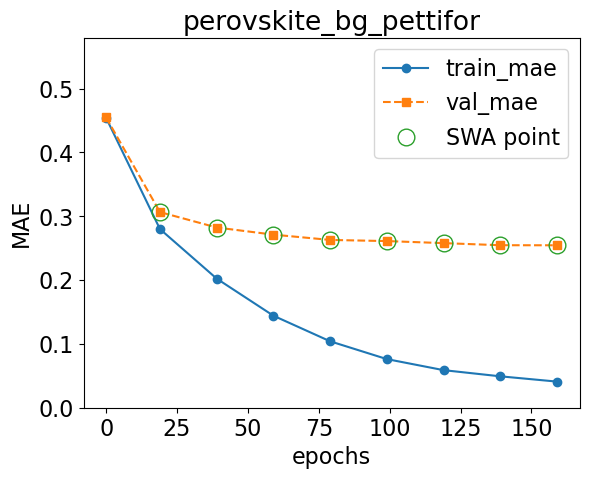

Epoch 179 failed to improve.
Discarded: 1/3 weight updates
Epoch: 179/300 --- train mae: 0.0352 val mae: 0.257


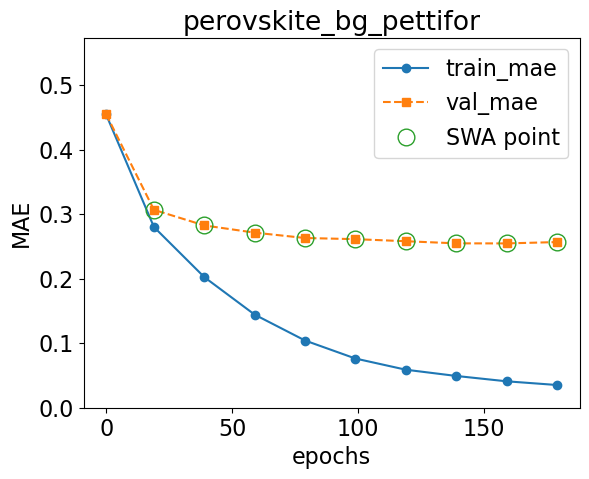

Epoch: 199/300 --- train mae: 0.0319 val mae: 0.254


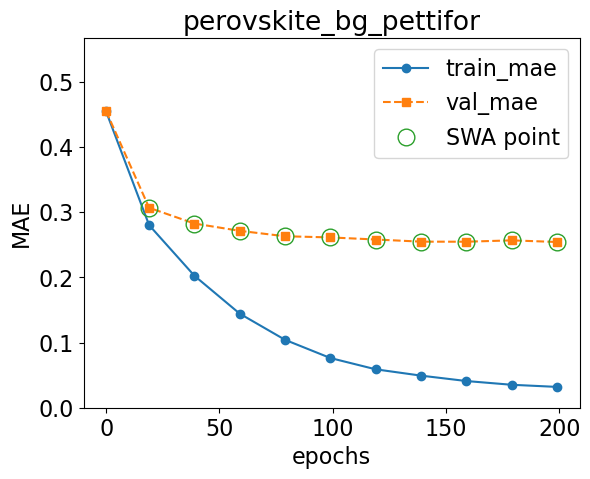

Epoch: 219/300 --- train mae: 0.0298 val mae: 0.255


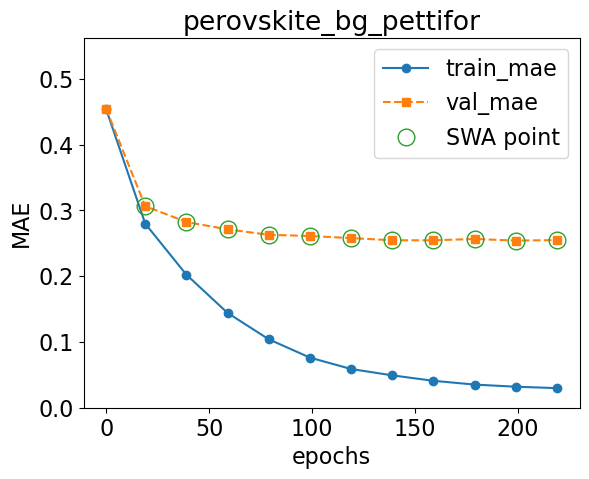

Epoch: 239/300 --- train mae: 0.0278 val mae: 0.254


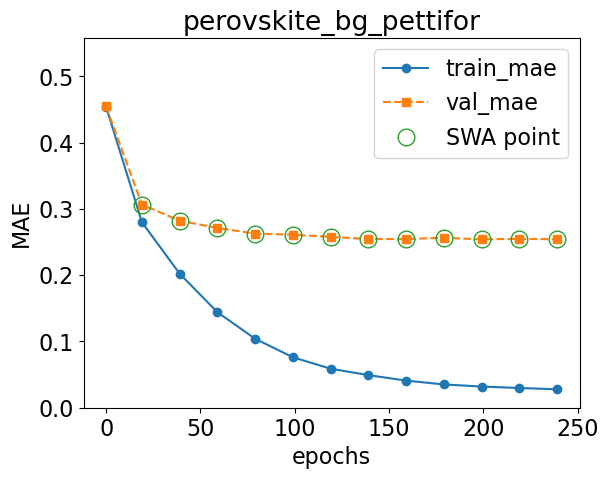

Epoch 259 failed to improve.
Discarded: 2/3 weight updates
Epoch: 259/300 --- train mae: 0.0264 val mae: 0.256


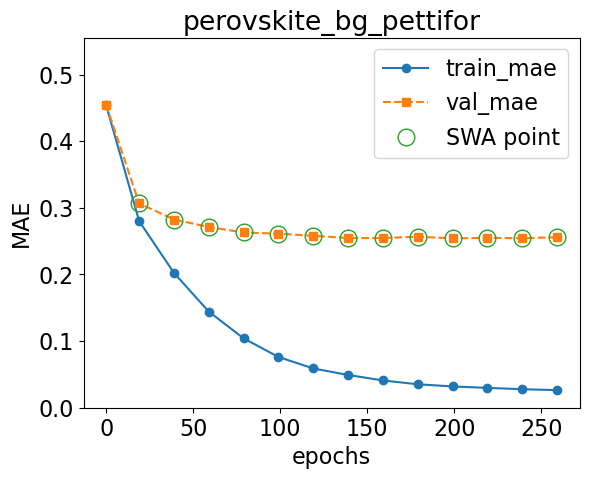

Epoch 279 failed to improve.
Discarded: 3/3 weight updates
Epoch: 279/300 --- train mae: 0.0255 val mae: 0.258


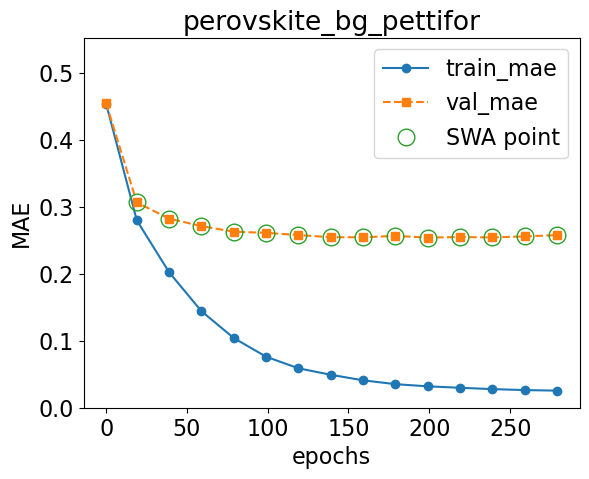

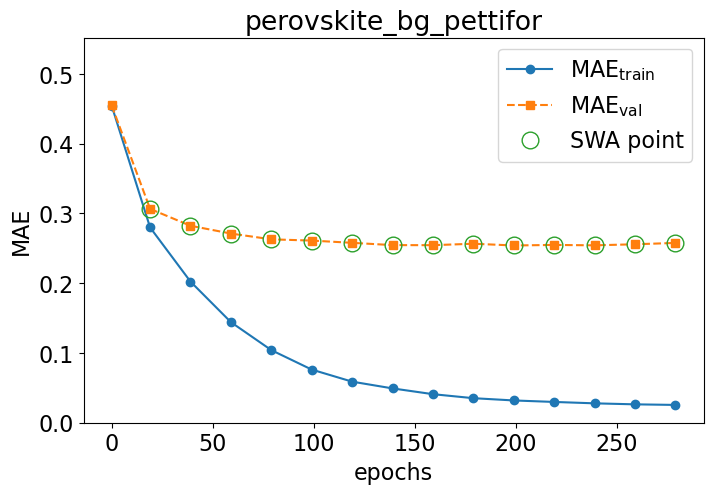

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_pettifor) to models/trained_models/perovskite_bg_pettifor.pth


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 222527.38formulae/s]

skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
R2 score: 0.3740
MSE: 0.2707
MAE: 0.2537 eV


,encoder,R²,MAE (eV),RMSE (eV)
4,pettifor,0.374,0.254,0.520
2,onehot,0.380,0.256,0.518
1,mat2vec,0.341,0.261,0.534
3,random_200,0.367,0.262,0.523
0,magpie,0.346,0.273,0.532


In [3]:
ENCODERS = ['magpie', 'mat2vec', 'onehot', 'random_200', 'pettifor']

# ENCODERS = [ 'onehot', 'pettifor']

encoder_results = []

for encoder in ENCODERS:
    print(f'\n{"="*50}')
    print(f'Encoder: {encoder}')
    print(f'{"="*50}')

    model_name = f'perovskite_bg_{encoder}'

    model = CrabNet(
        mat_prop='bandgap',
        model_name=model_name,
        elem_prop=encoder,
        learningcurve=True,
    )
    model.fit(train_base.copy(), val_base.copy())

    m = test_r2_score(
        test_base, feature_names=None,
        crabnet_bandgap=model, plot=False,
    )

    encoder_results.append({
        'encoder': encoder,
        'R²': m['r2'],
        'MAE (eV)': m['mae'],
        'RMSE (eV)': np.sqrt(m['mse']),
    })

enc_table = pd.DataFrame(encoder_results).sort_values('MAE (eV)')
enc_table.style.format({'R²': '{:.3f}', 'MAE (eV)': '{:.3f}', 'RMSE (eV)': '{:.3f}'})

## Comparison Bar Chart

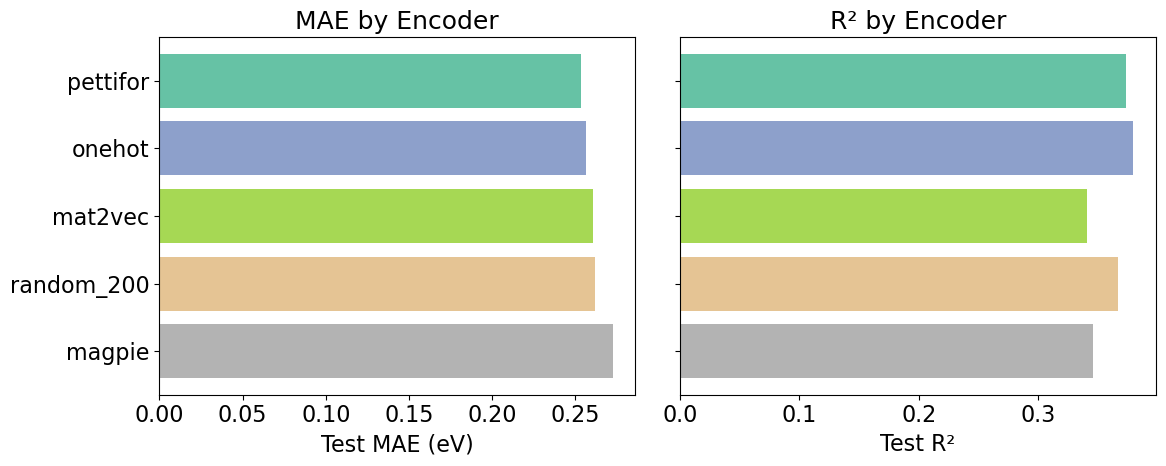

Saved to /home/dagar/TF-ChPVK-PV/reports/figures/encoder_comparison.png


In [5]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.set_context('talk')

colors = plt.cm.Set2(np.linspace(0, 1, len(enc_table)))

# MAE
axes[0].barh(enc_table['encoder'], enc_table['MAE (eV)'], color=colors)
axes[0].set_xlabel('Test MAE (eV)')
axes[0].set_title('MAE by Encoder')
axes[0].invert_yaxis()

# R²
axes[1].barh(enc_table['encoder'], enc_table['R²'], color=colors)
axes[1].set_xlabel('Test R²')
axes[1].set_title('R² by Encoder')

plt.tight_layout()
#fig.savefig(FIGURES_DIR / 'encoder_comparison.pdf')
fig.savefig(FIGURES_DIR / 'encoder_comparison.png')
plt.show()
print(f'Saved to {FIGURES_DIR / "encoder_comparison.png"}')